## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle



def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 200

randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/e' + str(i))

print(models, model_names)

inputs = ['a', 'b']
target = ['c']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/e0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 159us/step - loss: 1.1934 - mean_squared_error: 1.1934 - val_loss: 1.0473 - val_mean_squared_error: 1.0473

Epoch 00001: val_loss improved from inf to 1.04726, saving model to temp/e0
Epoch 2/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0496 - mean_squared_error: 1.0496 - val_loss: 1.0542 - val_mean_squared_error: 1.0542

Epoch 00002: val_loss did not improve from 1.04726
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0451 - mean_squared_error: 1.0451 - val_loss: 1.0521 - val_mean_squared_error: 1.0521

Epoch 00003: val_loss did not improve from 1.04726
Epoch 00003: early stopping
temp/e1
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.1769 - mean_squared_error: 1.1769 - val_loss: 1.0527 - val_mean_squared_error: 1.0527

Ep

20000/20000 [==============================] - 2s 119us/step - loss: 1.0382 - mean_squared_error: 1.0382 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00006: val_loss did not improve from 1.03383
Epoch 7/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0398 - mean_squared_error: 1.0398 - val_loss: 1.0310 - val_mean_squared_error: 1.0310

Epoch 00007: val_loss improved from 1.03383 to 1.03097, saving model to temp/e5
Epoch 8/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0362 - mean_squared_error: 1.0362 - val_loss: 1.0361 - val_mean_squared_error: 1.0361

Epoch 00008: val_loss did not improve from 1.03097
Epoch 9/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 1.0311 - val_mean_squared_error: 1.0311

Epoch 00009: val_loss did not improve from 1.03097
Epoch 00009: early stopping
temp/e6
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000


Epoch 00001: val_loss improved from inf to 1.04299, saving model to temp/e9
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0434 - mean_squared_error: 1.0434 - val_loss: 1.0392 - val_mean_squared_error: 1.0392

Epoch 00002: val_loss improved from 1.04299 to 1.03925, saving model to temp/e9
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 1.0364 - val_mean_squared_error: 1.0364

Epoch 00003: val_loss improved from 1.03925 to 1.03641, saving model to temp/e9
Epoch 4/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0468 - mean_squared_error: 1.0468 - val_loss: 1.0354 - val_mean_squared_error: 1.0354

Epoch 00004: val_loss improved from 1.03641 to 1.03538, saving model to temp/e9
Epoch 5/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0420 - mean_squared_error: 1.0420 - val_loss: 1.0357 - val_mean_squared_error: 1.0357

Epoch 0


Epoch 00008: val_loss did not improve from 1.03350
Epoch 00008: early stopping
temp/e14
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.1884 - mean_squared_error: 1.1884 - val_loss: 1.0483 - val_mean_squared_error: 1.0483

Epoch 00001: val_loss improved from inf to 1.04831, saving model to temp/e14
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0503 - mean_squared_error: 1.0503 - val_loss: 1.0403 - val_mean_squared_error: 1.0403

Epoch 00002: val_loss improved from 1.04831 to 1.04030, saving model to temp/e14
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0482 - mean_squared_error: 1.0482 - val_loss: 1.0482 - val_mean_squared_error: 1.0482

Epoch 00003: val_loss did not improve from 1.04030
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0426 - mean_squared_error: 1.0426 - val_loss: 1.0380 - val_mean


Epoch 00007: val_loss did not improve from 1.02964
Epoch 8/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0368 - mean_squared_error: 1.0368 - val_loss: 1.0372 - val_mean_squared_error: 1.0372

Epoch 00008: val_loss did not improve from 1.02964
Epoch 00008: early stopping
temp/e19
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.1813 - mean_squared_error: 1.1813 - val_loss: 1.0503 - val_mean_squared_error: 1.0503

Epoch 00001: val_loss improved from inf to 1.05027, saving model to temp/e19
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0494 - mean_squared_error: 1.0494 - val_loss: 1.0453 - val_mean_squared_error: 1.0453

Epoch 00002: val_loss improved from 1.05027 to 1.04525, saving model to temp/e19
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0464 - mean_squared_error: 1.0464 - val_loss: 1.0440 - val_mean

20000/20000 [==============================] - 3s 129us/step - loss: 1.0442 - mean_squared_error: 1.0442 - val_loss: 1.0385 - val_mean_squared_error: 1.0385

Epoch 00004: val_loss improved from 1.04019 to 1.03851, saving model to temp/e23
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0446 - mean_squared_error: 1.0446 - val_loss: 1.0461 - val_mean_squared_error: 1.0461

Epoch 00005: val_loss did not improve from 1.03851
Epoch 6/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0390 - mean_squared_error: 1.0390 - val_loss: 1.0377 - val_mean_squared_error: 1.0377

Epoch 00006: val_loss improved from 1.03851 to 1.03772, saving model to temp/e23
Epoch 7/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0429 - mean_squared_error: 1.0429 - val_loss: 1.0371 - val_mean_squared_error: 1.0371

Epoch 00007: val_loss improved from 1.03772 to 1.03714, saving model to temp/e23
Epoch 8/20
20000/20000 [=================


Epoch 00001: val_loss improved from inf to 1.04719, saving model to temp/e28
Epoch 2/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0495 - mean_squared_error: 1.0495 - val_loss: 1.0462 - val_mean_squared_error: 1.0462

Epoch 00002: val_loss improved from 1.04719 to 1.04624, saving model to temp/e28
Epoch 3/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0386 - mean_squared_error: 1.0386 - val_loss: 1.0468 - val_mean_squared_error: 1.0468

Epoch 00003: val_loss did not improve from 1.04624
Epoch 4/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 1.0403 - val_mean_squared_error: 1.0403

Epoch 00004: val_loss improved from 1.04624 to 1.04031, saving model to temp/e28
Epoch 5/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0411 - mean_squared_error: 1.0411 - val_loss: 1.0363 - val_mean_squared_error: 1.0363

Epoch 00005: val_loss improved fr

20000/20000 [==============================] - 3s 128us/step - loss: 1.0354 - mean_squared_error: 1.0354 - val_loss: 1.0395 - val_mean_squared_error: 1.0395

Epoch 00007: val_loss did not improve from 1.02980
Epoch 8/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0354 - mean_squared_error: 1.0354 - val_loss: 1.0281 - val_mean_squared_error: 1.0281

Epoch 00008: val_loss improved from 1.02980 to 1.02809, saving model to temp/e32
Epoch 9/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0374 - val_mean_squared_error: 1.0374

Epoch 00009: val_loss did not improve from 1.02809
Epoch 10/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 1.0356 - val_mean_squared_error: 1.0356

Epoch 00010: val_loss did not improve from 1.02809
Epoch 00010: early stopping
temp/e33
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20

20000/20000 [==============================] - 3s 140us/step - loss: 1.1938 - mean_squared_error: 1.1938 - val_loss: 1.0600 - val_mean_squared_error: 1.0600

Epoch 00001: val_loss improved from inf to 1.05998, saving model to temp/e37
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0454 - mean_squared_error: 1.0454 - val_loss: 1.0477 - val_mean_squared_error: 1.0477

Epoch 00002: val_loss improved from 1.05998 to 1.04767, saving model to temp/e37
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0447 - mean_squared_error: 1.0447 - val_loss: 1.0383 - val_mean_squared_error: 1.0383

Epoch 00003: val_loss improved from 1.04767 to 1.03825, saving model to temp/e37
Epoch 4/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0418 - mean_squared_error: 1.0418 - val_loss: 1.0427 - val_mean_squared_error: 1.0427

Epoch 00004: val_loss did not improve from 1.03825
Epoch 5/20
20000/20000 [=====================


Epoch 00003: val_loss did not improve from 1.04423
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0401 - mean_squared_error: 1.0401 - val_loss: 1.0521 - val_mean_squared_error: 1.0521

Epoch 00004: val_loss did not improve from 1.04423
Epoch 00004: early stopping
temp/e42
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.1861 - mean_squared_error: 1.1861 - val_loss: 1.0482 - val_mean_squared_error: 1.0482

Epoch 00001: val_loss improved from inf to 1.04821, saving model to temp/e42
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0486 - mean_squared_error: 1.0486 - val_loss: 1.0522 - val_mean_squared_error: 1.0522

Epoch 00002: val_loss did not improve from 1.04821
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0476 - mean_squared_error: 1.0476 - val_loss: 1.0407 - val_mean_squared_error: 1.0407

Epoch 

20000/20000 [==============================] - 3s 129us/step - loss: 1.0308 - mean_squared_error: 1.0308 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00010: val_loss did not improve from 1.03133
Epoch 11/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0382 - mean_squared_error: 1.0382 - val_loss: 1.0319 - val_mean_squared_error: 1.0319

Epoch 00011: val_loss did not improve from 1.03133
Epoch 00011: early stopping
temp/e46
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1681 - mean_squared_error: 1.1681 - val_loss: 1.0467 - val_mean_squared_error: 1.0467

Epoch 00001: val_loss improved from inf to 1.04671, saving model to temp/e46
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0506 - mean_squared_error: 1.0506 - val_loss: 1.0454 - val_mean_squared_error: 1.0454

Epoch 00002: val_loss improved from 1.04671 to 1.04537, saving model

20000/20000 [==============================] - 3s 132us/step - loss: 1.1891 - mean_squared_error: 1.1891 - val_loss: 1.0462 - val_mean_squared_error: 1.0462

Epoch 00001: val_loss improved from inf to 1.04623, saving model to temp/e51
Epoch 2/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0499 - mean_squared_error: 1.0499 - val_loss: 1.0467 - val_mean_squared_error: 1.0467

Epoch 00002: val_loss did not improve from 1.04623
Epoch 3/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0416 - mean_squared_error: 1.0416 - val_loss: 1.0356 - val_mean_squared_error: 1.0356

Epoch 00003: val_loss improved from 1.04623 to 1.03558, saving model to temp/e51
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0425 - mean_squared_error: 1.0425 - val_loss: 1.0456 - val_mean_squared_error: 1.0456

Epoch 00004: val_loss did not improve from 1.03558
Epoch 5/20
20000/20000 [==============================] - 2s 112us/step - l

20000/20000 [==============================] - 2s 122us/step - loss: 1.0444 - mean_squared_error: 1.0444 - val_loss: 1.0496 - val_mean_squared_error: 1.0496

Epoch 00004: val_loss did not improve from 1.04242
Epoch 00004: early stopping
temp/e57
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.2055 - mean_squared_error: 1.2055 - val_loss: 1.0540 - val_mean_squared_error: 1.0540

Epoch 00001: val_loss improved from inf to 1.05398, saving model to temp/e57
Epoch 2/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0492 - mean_squared_error: 1.0492 - val_loss: 1.0445 - val_mean_squared_error: 1.0445

Epoch 00002: val_loss improved from 1.05398 to 1.04451, saving model to temp/e57
Epoch 3/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0451 - mean_squared_error: 1.0451 - val_loss: 1.0447 - val_mean_squared_error: 1.0447

Epoch 00003: val_loss did not improve f

20000/20000 [==============================] - 3s 129us/step - loss: 1.0446 - mean_squared_error: 1.0446 - val_loss: 1.0431 - val_mean_squared_error: 1.0431

Epoch 00003: val_loss improved from 1.04682 to 1.04315, saving model to temp/e61
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0365 - mean_squared_error: 1.0365 - val_loss: 1.0363 - val_mean_squared_error: 1.0363

Epoch 00004: val_loss improved from 1.04315 to 1.03632, saving model to temp/e61
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0414 - mean_squared_error: 1.0414 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00005: val_loss improved from 1.03632 to 1.03458, saving model to temp/e61
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0399 - mean_squared_error: 1.0399 - val_loss: 1.0405 - val_mean_squared_error: 1.0405

Epoch 00006: val_loss did not improve from 1.03458
Epoch 7/20
20000/20000 [=================

20000/20000 [==============================] - 3s 129us/step - loss: 1.0430 - mean_squared_error: 1.0430 - val_loss: 1.0307 - val_mean_squared_error: 1.0307

Epoch 00003: val_loss improved from 1.04856 to 1.03065, saving model to temp/e65
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0443 - mean_squared_error: 1.0443 - val_loss: 1.0383 - val_mean_squared_error: 1.0383

Epoch 00004: val_loss did not improve from 1.03065
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 1.0306 - val_mean_squared_error: 1.0306

Epoch 00005: val_loss improved from 1.03065 to 1.03061, saving model to temp/e65
Epoch 00005: early stopping
temp/e66
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1636 - mean_squared_error: 1.1636 - val_loss: 1.0510 - val_mean_squared_error: 1.0510

Epoch 00001: val_loss improved from

20000/20000 [==============================] - 3s 130us/step - loss: 1.0370 - mean_squared_error: 1.0370 - val_loss: 1.0365 - val_mean_squared_error: 1.0365

Epoch 00006: val_loss did not improve from 1.03619
Epoch 7/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0405 - mean_squared_error: 1.0405 - val_loss: 1.0484 - val_mean_squared_error: 1.0484

Epoch 00007: val_loss did not improve from 1.03619
Epoch 00007: early stopping
temp/e71
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1714 - mean_squared_error: 1.1714 - val_loss: 1.0453 - val_mean_squared_error: 1.0453

Epoch 00001: val_loss improved from inf to 1.04526, saving model to temp/e71
Epoch 2/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0483 - mean_squared_error: 1.0483 - val_loss: 1.0410 - val_mean_squared_error: 1.0410

Epoch 00002: val_loss improved from 1.04526 to 1.04105, saving model 

20000/20000 [==============================] - 2s 105us/step - loss: 1.0464 - mean_squared_error: 1.0464 - val_loss: 1.0418 - val_mean_squared_error: 1.0418

Epoch 00002: val_loss improved from 1.04340 to 1.04181, saving model to temp/e77
Epoch 3/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0477 - mean_squared_error: 1.0477 - val_loss: 1.0381 - val_mean_squared_error: 1.0381

Epoch 00003: val_loss improved from 1.04181 to 1.03808, saving model to temp/e77
Epoch 4/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0391 - mean_squared_error: 1.0391 - val_loss: 1.0386 - val_mean_squared_error: 1.0386

Epoch 00004: val_loss did not improve from 1.03808
Epoch 5/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 1.0379 - val_mean_squared_error: 1.0379

Epoch 00005: val_loss improved from 1.03808 to 1.03794, saving model to temp/e77
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 2s 118us/step - loss: 1.0350 - mean_squared_error: 1.0350 - val_loss: 1.0292 - val_mean_squared_error: 1.0292

Epoch 00008: val_loss improved from 1.03375 to 1.02923, saving model to temp/e81
Epoch 9/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0331 - mean_squared_error: 1.0331 - val_loss: 1.0322 - val_mean_squared_error: 1.0322

Epoch 00009: val_loss did not improve from 1.02923
Epoch 10/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0358 - mean_squared_error: 1.0358 - val_loss: 1.0339 - val_mean_squared_error: 1.0339

Epoch 00010: val_loss did not improve from 1.02923
Epoch 00010: early stopping
temp/e82
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.1746 - mean_squared_error: 1.1746 - val_loss: 1.0456 - val_mean_squared_error: 1.0456

Epoch 00001: val_loss improved from inf to 1.04560, saving model


Epoch 00001: val_loss improved from inf to 1.04807, saving model to temp/e87
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0494 - mean_squared_error: 1.0494 - val_loss: 1.0517 - val_mean_squared_error: 1.0517

Epoch 00002: val_loss did not improve from 1.04807
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0430 - mean_squared_error: 1.0430 - val_loss: 1.0382 - val_mean_squared_error: 1.0382

Epoch 00003: val_loss improved from 1.04807 to 1.03820, saving model to temp/e87
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0404 - mean_squared_error: 1.0404 - val_loss: 1.0335 - val_mean_squared_error: 1.0335

Epoch 00004: val_loss improved from 1.03820 to 1.03347, saving model to temp/e87
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0475 - val_mean_squared_error: 1.0475

Epoch 00005: val_loss did not imp


Epoch 00004: val_loss improved from 1.03926 to 1.03479, saving model to temp/e92
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0353 - mean_squared_error: 1.0353 - val_loss: 1.0327 - val_mean_squared_error: 1.0327

Epoch 00005: val_loss improved from 1.03479 to 1.03273, saving model to temp/e92
Epoch 6/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0373 - mean_squared_error: 1.0373 - val_loss: 1.0373 - val_mean_squared_error: 1.0373

Epoch 00006: val_loss did not improve from 1.03273
Epoch 7/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0363 - mean_squared_error: 1.0363 - val_loss: 1.0339 - val_mean_squared_error: 1.0339

Epoch 00007: val_loss did not improve from 1.03273
Epoch 00007: early stopping
temp/e93
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.1964 - mean_squared_error: 1.1964 - val_loss: 1.0463 - val_


Epoch 00002: val_loss improved from 1.05829 to 1.04250, saving model to temp/e97
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 1.0429 - val_mean_squared_error: 1.0429

Epoch 00003: val_loss did not improve from 1.04250
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 1.0371 - val_mean_squared_error: 1.0371

Epoch 00004: val_loss improved from 1.04250 to 1.03708, saving model to temp/e97
Epoch 5/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0399 - mean_squared_error: 1.0399 - val_loss: 1.0550 - val_mean_squared_error: 1.0550

Epoch 00005: val_loss did not improve from 1.03708
Epoch 6/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0353 - mean_squared_error: 1.0353 - val_loss: 1.0333 - val_mean_squared_error: 1.0333

Epoch 00006: val_loss improved from 1.03708 to 1.03330, sav

20000/20000 [==============================] - 3s 128us/step - loss: 1.0399 - mean_squared_error: 1.0399 - val_loss: 1.0380 - val_mean_squared_error: 1.0380

Epoch 00007: val_loss did not improve from 1.03012
Epoch 8/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0341 - mean_squared_error: 1.0341 - val_loss: 1.0314 - val_mean_squared_error: 1.0314

Epoch 00008: val_loss did not improve from 1.03012
Epoch 00008: early stopping
temp/e102
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.1920 - mean_squared_error: 1.1920 - val_loss: 1.0526 - val_mean_squared_error: 1.0526

Epoch 00001: val_loss improved from inf to 1.05262, saving model to temp/e102
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0480 - mean_squared_error: 1.0480 - val_loss: 1.0488 - val_mean_squared_error: 1.0488

Epoch 00002: val_loss improved from 1.05262 to 1.04880, saving mode

20000/20000 [==============================] - 2s 107us/step - loss: 1.0392 - mean_squared_error: 1.0392 - val_loss: 1.0416 - val_mean_squared_error: 1.0416

Epoch 00004: val_loss improved from 1.04579 to 1.04158, saving model to temp/e106
Epoch 5/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0405 - mean_squared_error: 1.0405 - val_loss: 1.0310 - val_mean_squared_error: 1.0310

Epoch 00005: val_loss improved from 1.04158 to 1.03097, saving model to temp/e106
Epoch 6/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0435 - mean_squared_error: 1.0435 - val_loss: 1.0536 - val_mean_squared_error: 1.0536

Epoch 00006: val_loss did not improve from 1.03097
Epoch 7/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0418 - mean_squared_error: 1.0418 - val_loss: 1.0415 - val_mean_squared_error: 1.0415

Epoch 00007: val_loss did not improve from 1.03097
Epoch 00007: early stopping
temp/e107
Train on 20000 samples, validat

20000/20000 [==============================] - 3s 129us/step - loss: 1.0355 - mean_squared_error: 1.0355 - val_loss: 1.0422 - val_mean_squared_error: 1.0422

Epoch 00011: val_loss did not improve from 1.02773
Epoch 00011: early stopping
temp/e112
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.1586 - mean_squared_error: 1.1586 - val_loss: 1.0602 - val_mean_squared_error: 1.0602

Epoch 00001: val_loss improved from inf to 1.06020, saving model to temp/e112
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0473 - mean_squared_error: 1.0473 - val_loss: 1.0469 - val_mean_squared_error: 1.0469

Epoch 00002: val_loss improved from 1.06020 to 1.04688, saving model to temp/e112
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0479 - mean_squared_error: 1.0479 - val_loss: 1.0394 - val_mean_squared_error: 1.0394

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 134us/step - loss: 1.1936 - mean_squared_error: 1.1936 - val_loss: 1.0483 - val_mean_squared_error: 1.0483

Epoch 00001: val_loss improved from inf to 1.04833, saving model to temp/e117
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0492 - mean_squared_error: 1.0492 - val_loss: 1.0453 - val_mean_squared_error: 1.0453

Epoch 00002: val_loss improved from 1.04833 to 1.04529, saving model to temp/e117
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0475 - mean_squared_error: 1.0475 - val_loss: 1.0422 - val_mean_squared_error: 1.0422

Epoch 00003: val_loss improved from 1.04529 to 1.04215, saving model to temp/e117
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0412 - mean_squared_error: 1.0412 - val_loss: 1.0401 - val_mean_squared_error: 1.0401

Epoch 00004: val_loss improved from 1.04215 to 1.04009, saving model to temp/e117
Epoch 5/20


Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.1909 - mean_squared_error: 1.1909 - val_loss: 1.0459 - val_mean_squared_error: 1.0459

Epoch 00001: val_loss improved from inf to 1.04589, saving model to temp/e122
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0497 - mean_squared_error: 1.0497 - val_loss: 1.0331 - val_mean_squared_error: 1.0331

Epoch 00002: val_loss improved from 1.04589 to 1.03311, saving model to temp/e122
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0413 - mean_squared_error: 1.0413 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00003: val_loss did not improve from 1.03311
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0393 - mean_squared_error: 1.0393 - val_loss: 1.0415 - val_mean_squared_error: 1.0415

Epoch 00004: val_loss did not improve from 1.03311
Epoch 00004:

20000/20000 [==============================] - 3s 127us/step - loss: 1.0480 - mean_squared_error: 1.0480 - val_loss: 1.0418 - val_mean_squared_error: 1.0418

Epoch 00003: val_loss did not improve from 1.04119
Epoch 4/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0418 - mean_squared_error: 1.0418 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00004: val_loss improved from 1.04119 to 1.03457, saving model to temp/e127
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0375 - mean_squared_error: 1.0375 - val_loss: 1.0385 - val_mean_squared_error: 1.0385

Epoch 00005: val_loss did not improve from 1.03457
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0362 - mean_squared_error: 1.0362 - val_loss: 1.0333 - val_mean_squared_error: 1.0333

Epoch 00006: val_loss improved from 1.03457 to 1.03325, saving model to temp/e127
Epoch 7/20
20000/20000 [==============================] - 3s 128us/st

20000/20000 [==============================] - 3s 128us/step - loss: 1.0351 - mean_squared_error: 1.0351 - val_loss: 1.0349 - val_mean_squared_error: 1.0349

Epoch 00008: val_loss did not improve from 1.03170
Epoch 9/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0353 - mean_squared_error: 1.0353 - val_loss: 1.0312 - val_mean_squared_error: 1.0312

Epoch 00009: val_loss improved from 1.03170 to 1.03118, saving model to temp/e131
Epoch 10/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0359 - mean_squared_error: 1.0359 - val_loss: 1.0291 - val_mean_squared_error: 1.0291

Epoch 00010: val_loss improved from 1.03118 to 1.02912, saving model to temp/e131
Epoch 11/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0340 - mean_squared_error: 1.0340 - val_loss: 1.0310 - val_mean_squared_error: 1.0310

Epoch 00011: val_loss did not improve from 1.02912
Epoch 12/20
20000/20000 [==============================] - 3s 130us


Epoch 00003: val_loss improved from 1.04508 to 1.04488, saving model to temp/e137
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 1.0349 - val_mean_squared_error: 1.0349

Epoch 00004: val_loss improved from 1.04488 to 1.03492, saving model to temp/e137
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0427 - mean_squared_error: 1.0427 - val_loss: 1.0403 - val_mean_squared_error: 1.0403

Epoch 00005: val_loss did not improve from 1.03492
Epoch 6/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0430 - mean_squared_error: 1.0430 - val_loss: 1.0329 - val_mean_squared_error: 1.0329

Epoch 00006: val_loss improved from 1.03492 to 1.03294, saving model to temp/e137
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0497 - val_mean_squared_error: 1.0497

Epoch 00007: val_loss did 

20000/20000 [==============================] - 3s 126us/step - loss: 1.0384 - mean_squared_error: 1.0384 - val_loss: 1.0518 - val_mean_squared_error: 1.0518

Epoch 00004: val_loss did not improve from 1.03812
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0473 - mean_squared_error: 1.0473 - val_loss: 1.0402 - val_mean_squared_error: 1.0402

Epoch 00005: val_loss did not improve from 1.03812
Epoch 00005: early stopping
temp/e143
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1712 - mean_squared_error: 1.1712 - val_loss: 1.0501 - val_mean_squared_error: 1.0501

Epoch 00001: val_loss improved from inf to 1.05006, saving model to temp/e143
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0495 - mean_squared_error: 1.0495 - val_loss: 1.0371 - val_mean_squared_error: 1.0371

Epoch 00002: val_loss improved from 1.05006 to 1.03710, saving mode

20000/20000 [==============================] - 3s 129us/step - loss: 1.0342 - mean_squared_error: 1.0342 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00007: val_loss did not improve from 1.03430
Epoch 00007: early stopping
temp/e147
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 142us/step - loss: 1.1703 - mean_squared_error: 1.1703 - val_loss: 1.0533 - val_mean_squared_error: 1.0533

Epoch 00001: val_loss improved from inf to 1.05334, saving model to temp/e147
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0472 - mean_squared_error: 1.0472 - val_loss: 1.0362 - val_mean_squared_error: 1.0362

Epoch 00002: val_loss improved from 1.05334 to 1.03618, saving model to temp/e147
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0465 - mean_squared_error: 1.0465 - val_loss: 1.0367 - val_mean_squared_error: 1.0367

Epoch 00003: val_loss did not improv

20000/20000 [==============================] - 3s 131us/step - loss: 1.1852 - mean_squared_error: 1.1852 - val_loss: 1.0534 - val_mean_squared_error: 1.0534

Epoch 00001: val_loss improved from inf to 1.05338, saving model to temp/e152
Epoch 2/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 1.0437 - val_mean_squared_error: 1.0437

Epoch 00002: val_loss improved from 1.05338 to 1.04374, saving model to temp/e152
Epoch 3/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0476 - mean_squared_error: 1.0476 - val_loss: 1.0429 - val_mean_squared_error: 1.0429

Epoch 00003: val_loss improved from 1.04374 to 1.04294, saving model to temp/e152
Epoch 4/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0408 - mean_squared_error: 1.0408 - val_loss: 1.0383 - val_mean_squared_error: 1.0383

Epoch 00004: val_loss improved from 1.04294 to 1.03834, saving model to temp/e152
Epoch 5/20


20000/20000 [==============================] - 3s 128us/step - loss: 1.0345 - mean_squared_error: 1.0345 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00008: val_loss did not improve from 1.02937
Epoch 9/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0385 - mean_squared_error: 1.0385 - val_loss: 1.0302 - val_mean_squared_error: 1.0302

Epoch 00009: val_loss did not improve from 1.02937
Epoch 00009: early stopping
temp/e157
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.1766 - mean_squared_error: 1.1766 - val_loss: 1.0474 - val_mean_squared_error: 1.0474

Epoch 00001: val_loss improved from inf to 1.04739, saving model to temp/e157
Epoch 2/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0476 - mean_squared_error: 1.0476 - val_loss: 1.0505 - val_mean_squared_error: 1.0505

Epoch 00002: val_loss did not improve from 1.04739
Epoch 3/20
20000

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.2137 - mean_squared_error: 1.2137 - val_loss: 1.0552 - val_mean_squared_error: 1.0552

Epoch 00001: val_loss improved from inf to 1.05523, saving model to temp/e162
Epoch 2/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0457 - mean_squared_error: 1.0457 - val_loss: 1.0503 - val_mean_squared_error: 1.0503

Epoch 00002: val_loss improved from 1.05523 to 1.05029, saving model to temp/e162
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0411 - mean_squared_error: 1.0411 - val_loss: 1.0429 - val_mean_squared_error: 1.0429

Epoch 00003: val_loss improved from 1.05029 to 1.04287, saving model to temp/e162
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0422 - mean_squared_error: 1.0422 - val_loss: 1.0412 - val_mean_squared_error: 1.0412

Epoch 00004: val_loss improved f

20000/20000 [==============================] - 2s 105us/step - loss: 1.0356 - mean_squared_error: 1.0356 - val_loss: 1.0369 - val_mean_squared_error: 1.0369

Epoch 00008: val_loss did not improve from 1.03124
Epoch 00008: early stopping
temp/e166
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1943 - mean_squared_error: 1.1943 - val_loss: 1.0447 - val_mean_squared_error: 1.0447

Epoch 00001: val_loss improved from inf to 1.04470, saving model to temp/e166
Epoch 2/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0500 - mean_squared_error: 1.0500 - val_loss: 1.0532 - val_mean_squared_error: 1.0532

Epoch 00002: val_loss did not improve from 1.04470
Epoch 3/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0474 - mean_squared_error: 1.0474 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00003: val_loss improved from 1.04470 to 1.04434, saving mode

20000/20000 [==============================] - 3s 128us/step - loss: 1.0381 - mean_squared_error: 1.0381 - val_loss: 1.0353 - val_mean_squared_error: 1.0353

Epoch 00005: val_loss improved from 1.03665 to 1.03531, saving model to temp/e170
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0367 - mean_squared_error: 1.0367 - val_loss: 1.0379 - val_mean_squared_error: 1.0379

Epoch 00006: val_loss did not improve from 1.03531
Epoch 7/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0361 - mean_squared_error: 1.0361 - val_loss: 1.0307 - val_mean_squared_error: 1.0307

Epoch 00007: val_loss improved from 1.03531 to 1.03072, saving model to temp/e170
Epoch 8/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0383 - mean_squared_error: 1.0383 - val_loss: 1.0399 - val_mean_squared_error: 1.0399

Epoch 00008: val_loss did not improve from 1.03072
Epoch 9/20
20000/20000 [==============================] - 3s 128us/st


Epoch 00008: val_loss did not improve from 1.03135
Epoch 00008: early stopping
temp/e174
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.1816 - mean_squared_error: 1.1816 - val_loss: 1.0420 - val_mean_squared_error: 1.0420

Epoch 00001: val_loss improved from inf to 1.04203, saving model to temp/e174
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0532 - mean_squared_error: 1.0532 - val_loss: 1.0382 - val_mean_squared_error: 1.0382

Epoch 00002: val_loss improved from 1.04203 to 1.03821, saving model to temp/e174
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0421 - mean_squared_error: 1.0421 - val_loss: 1.0422 - val_mean_squared_error: 1.0422

Epoch 00003: val_loss did not improve from 1.03821
Epoch 4/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0464 - mean_squared_error: 1.0464 - val_loss: 1.0475 - val_m

20000/20000 [==============================] - 2s 100us/step - loss: 1.0408 - mean_squared_error: 1.0408 - val_loss: 1.0498 - val_mean_squared_error: 1.0498

Epoch 00004: val_loss did not improve from 1.03707
Epoch 00004: early stopping
temp/e180
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.1651 - mean_squared_error: 1.1651 - val_loss: 1.0471 - val_mean_squared_error: 1.0471

Epoch 00001: val_loss improved from inf to 1.04709, saving model to temp/e180
Epoch 2/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 1.0370 - val_mean_squared_error: 1.0370

Epoch 00002: val_loss improved from 1.04709 to 1.03698, saving model to temp/e180
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0427 - mean_squared_error: 1.0427 - val_loss: 1.0416 - val_mean_squared_error: 1.0416

Epoch 00003: val_loss did not improv


Epoch 00001: val_loss improved from inf to 1.04282, saving model to temp/e184
Epoch 2/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0503 - mean_squared_error: 1.0503 - val_loss: 1.0434 - val_mean_squared_error: 1.0434

Epoch 00002: val_loss did not improve from 1.04282
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0454 - mean_squared_error: 1.0454 - val_loss: 1.0424 - val_mean_squared_error: 1.0424

Epoch 00003: val_loss improved from 1.04282 to 1.04244, saving model to temp/e184
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0412 - mean_squared_error: 1.0412 - val_loss: 1.0349 - val_mean_squared_error: 1.0349

Epoch 00004: val_loss improved from 1.04244 to 1.03491, saving model to temp/e184
Epoch 5/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0428 - mean_squared_error: 1.0428 - val_loss: 1.0379 - val_mean_squared_error: 1.0379

Epoch 00005: val_loss did not 

20000/20000 [==============================] - 3s 127us/step - loss: 1.0392 - mean_squared_error: 1.0392 - val_loss: 1.0354 - val_mean_squared_error: 1.0354

Epoch 00009: val_loss did not improve from 1.02378
Epoch 10/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0348 - mean_squared_error: 1.0348 - val_loss: 1.0317 - val_mean_squared_error: 1.0317

Epoch 00010: val_loss did not improve from 1.02378
Epoch 00010: early stopping
temp/e187
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.1839 - mean_squared_error: 1.1839 - val_loss: 1.0520 - val_mean_squared_error: 1.0520

Epoch 00001: val_loss improved from inf to 1.05199, saving model to temp/e187
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0477 - mean_squared_error: 1.0477 - val_loss: 1.0368 - val_mean_squared_error: 1.0368

Epoch 00002: val_loss improved from 1.05199 to 1.03682, saving mod

20000/20000 [==============================] - 3s 129us/step - loss: 1.0469 - mean_squared_error: 1.0469 - val_loss: 1.0357 - val_mean_squared_error: 1.0357

Epoch 00002: val_loss improved from 1.05627 to 1.03566, saving model to temp/e190
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0483 - mean_squared_error: 1.0483 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00003: val_loss did not improve from 1.03566
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0440 - mean_squared_error: 1.0440 - val_loss: 1.0419 - val_mean_squared_error: 1.0419

Epoch 00004: val_loss did not improve from 1.03566
Epoch 00004: early stopping
temp/e191
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 142us/step - loss: 1.1697 - mean_squared_error: 1.1697 - val_loss: 1.0461 - val_mean_squared_error: 1.0461

Epoch 00001: val_loss improved from inf to 1.04608, saving mode

20000/20000 [==============================] - 3s 130us/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 1.0440 - val_mean_squared_error: 1.0440

Epoch 00004: val_loss did not improve from 1.03899
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0351 - mean_squared_error: 1.0351 - val_loss: 1.0364 - val_mean_squared_error: 1.0364

Epoch 00005: val_loss improved from 1.03899 to 1.03638, saving model to temp/e195
Epoch 6/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0356 - mean_squared_error: 1.0356 - val_loss: 1.0474 - val_mean_squared_error: 1.0474

Epoch 00006: val_loss did not improve from 1.03638
Epoch 7/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0378 - mean_squared_error: 1.0378 - val_loss: 1.0324 - val_mean_squared_error: 1.0324

Epoch 00007: val_loss improved from 1.03638 to 1.03241, saving model to temp/e195
Epoch 8/20
20000/20000 [==============================] - 3s 130us/st

In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1, 2, 3]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 100
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = get_shap(model, x_test2, nshap)
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/e0
0.4761157502233694
[0.8468680170292405, 1.1053634834174983]
temp/e1
0.4840480317577017
[0.8422287756128365, 1.125867287902567]
temp/e2
0.5017377623406672
[0.8628999322299344, 1.1405755924514]
temp/e3
0.48031672480025267
[0.846655023418209, 1.1139784261822965]
temp/e4
0.47982660836145963
[0.852936939113911, 1.1067162776090083]
temp/e5
0.4938874344960309
[0.8478256637170152, 1.1399492052750466]
temp/e6
0.4831198475548881
[0.8431582481691337, 1.1230814469406427]
temp/e7
0.4798031052734646
[0.844337745735928, 1.1152684648110012]
temp/e8
0.4764618996122596
[0.839212658618491, 1.1137111406060283]
temp/e9
0.499431210606992
[0.8659939116641452, 1.132868509549839]
temp/e10
0.49828910028642215
[0.8763713089136422, 1.120206891659202]
temp/e11
0.4708423219156562
[0.8338527079249763, 1.1078319359063362]
temp/e12
0.496083946461901
[0.862564165261784, 1.129603727662018]
temp/e13
0.49035692041503043
[0.853084840503398, 1.127629000326663]
temp/e14
0.4856803004800513
[0.848482272419

0.4822773959014476
[0.8545607783287977, 1.1099940134740975]
temp/e120
0.4751044395312751
[0.8287931925687785, 1.1214156864937719]
temp/e121
0.4773091744178165
[0.8477146273075701, 1.106903721528063]
temp/e122
0.46588892603254406
[0.8231892838759554, 1.1085885681891328]
temp/e123
0.4753681443609049
[0.8601901885470532, 1.0905461001747567]
temp/e124
0.4869640795273409
[0.8382805479687886, 1.1356476110858933]
temp/e125
0.47407724006853835
[0.8468874031305201, 1.1012670770065567]
temp/e126
0.4765287844942794
[0.8531534021840547, 1.0999041668045042]
temp/e127
0.4854017363485553
[0.8541493784447047, 1.116654094252406]
temp/e128
0.4714200974545186
[0.8233763980442598, 1.1194637968647776]
temp/e129
0.45277060820077586
[0.8001743686699844, 1.1053668477315675]
temp/e130
0.46436627184157686
[0.8251433232083507, 1.103589220474803]
temp/e131
0.4572217965014894
[0.8067020131999518, 1.107741579803027]
temp/e132
0.5078552570531079
[0.8413550706913888, 1.174355443414827]
temp/e133
0.46453864154743174
[

1.4287032676926894
[1.613538098509876, 2.2438684368755033]
temp/e39
1.4145969060494714
[1.556405212668996, 2.272788599429947]
temp/e40
1.4016563364456855
[1.6194310944198969, 2.1838815784714747]
temp/e41
1.3890878779259634
[1.5682676108303442, 2.209908145021583]
temp/e42
1.3830818123097899
[1.5377590341201337, 2.228404590499446]
temp/e43
1.41979093040956
[1.5840312233745524, 2.2555506374445677]
temp/e44
1.3971985398210198
[1.5486625008283168, 2.245734578813723]
temp/e45
1.4433699361784216
[1.6507810204265012, 2.2359588519303424]
temp/e46
1.4234468793103425
[1.631625769284473, 2.2152679893362124]
temp/e47
1.4113601234226074
[1.6005179834583445, 2.2222022633868708]
temp/e48
1.4349864137853419
[1.6062367635702186, 2.263736064000465]
temp/e49
1.4164542055754588
[1.6284641273155414, 2.2044442838353766]
temp/e50
1.4235639701406255
[1.60850744818928, 2.2386204920919712]
temp/e51
1.3981611274524979
[1.561438143575206, 2.23488411132979]
temp/e52
1.4497540786021115
[1.6402985988587324, 2.2592095

1.4415662761205639
[1.6136395269381512, 2.269493025302977]
temp/e159
1.4164008087104079
[1.561109476497657, 2.2716921409231587]
temp/e160
1.453086181808851
[1.6205054174287492, 2.285666946188953]
temp/e161
1.4090327293455
[1.561782708428736, 2.2562827502622644]
temp/e162
1.4458170118043547
[1.5921027053900207, 2.299531318218689]
temp/e163
1.4281195333297083
[1.6463279971684919, 2.209911069490925]
temp/e164
1.4415502321086406
[1.6067245491524254, 2.276375915064856]
temp/e165
1.4133677570937202
[1.5894081877589208, 2.23732732642852]
temp/e166
1.4249323692764477
[1.578142751618556, 2.2717219869343395]
temp/e167
1.4743369360683514
[1.6704303119435102, 2.2782435601931925]
temp/e168
1.4416575534185387
[1.6152221360480226, 2.268092970789055]
temp/e169
1.3780971957376877
[1.5244244648070822, 2.2317699266682935]
temp/e170
1.4477390947047537
[1.6362723261530383, 2.259205863256469]
temp/e171
1.4116724214617076
[1.589244243375279, 2.2341005995481367]
temp/e172
1.4169039028584574
[1.563091719023932

2.4565193197592157
[2.584106241456616, 3.328932398061815]
temp/e80
2.5205869798503384
[2.6778185584771212, 3.3633554012235556]
temp/e81
2.4562381970479628
[2.6676393421206424, 3.2448370519752836]
temp/e82
2.443386507942404
[2.638813145464447, 3.2479598704203614]
temp/e83
2.4357010547473967
[2.605944489285589, 3.2654576202092045]
temp/e84
2.4786368448016356
[2.7441176538371894, 3.2131560357660813]
temp/e85
2.409594436865797
[2.5060002585200274, 3.3131886152115664]
temp/e86
2.485995687506521
[2.686154807449146, 3.2858365675638965]
temp/e87
2.4527041683816293
[2.616564749503886, 3.288843587259373]
temp/e88
2.5325684565176516
[2.7341487351810745, 3.3309881778542287]
temp/e89
2.54412702440077
[2.651504650521105, 3.4367493982804347]
temp/e90
2.430016726527528
[2.6017049455138563, 3.2583285075412]
temp/e91
2.491274852139333
[2.716954805164251, 3.2655948991144146]
temp/e92
2.491869985073156
[2.700446933061745, 3.283293037084566]
temp/e93
2.5152852232848115
[2.6318222782816996, 3.39874816828792

2.4189715187425964
[2.562219911200393, 3.2757231262848]
<<<<<<<< 1 1
temp/e0
0.5090161188416279
[0.854845531231113, 1.1631867064521428]
temp/e1
0.501843435745034
[0.8329368358196656, 1.1707500356704024]
temp/e2
0.5358749993307004
[0.8726675080249413, 1.1990824906364594]
temp/e3
0.5272661490790354
[0.8614258436124912, 1.1931064545455796]
temp/e4
0.5193564510924847
[0.8683698821922928, 1.1703430199926768]
temp/e5
0.5181476297338149
[0.8557365699755988, 1.180558689492031]
temp/e6
0.5043225724628919
[0.8439305838234935, 1.1647145611022904]
temp/e7
0.5051558078116769
[0.8502481552093235, 1.1600634604140303]
temp/e8
0.5005514474422005
[0.8428990771697356, 1.1582038177146654]
temp/e9
0.5342925037012528
[0.8819560505995412, 1.1866289568029644]
temp/e10
0.5011091934045131
[0.8709497404868194, 1.1312686463222068]
temp/e11
0.49826218735832795
[0.8391858472892163, 1.1573385274274397]
temp/e12
0.5137165481847139
[0.855014902081945, 1.172418194287483]
temp/e13
0.5234817894884016
[0.8712748813195924,

0.5057881221003773
[0.8187424977006714, 1.1928337465000831]
temp/e119
0.4967875108509151
[0.8539942694684478, 1.1395807522333825]
temp/e120
0.48457995208974247
[0.8259575914385278, 1.1432023127409572]
temp/e121
0.4953373559930927
[0.8607374818505223, 1.1299372301356632]
temp/e122
0.502322717027232
[0.8333808260410206, 1.1712646080134435]
temp/e123
0.4660051692287187
[0.826820195176919, 1.1051901432805185]
temp/e124
0.5257380731933071
[0.8622962290285651, 1.1891799173580493]
temp/e125
0.5016231795328756
[0.8373206400964633, 1.165925718969288]
temp/e126
0.5042567996165787
[0.8721969626519472, 1.13631663658121]
temp/e127
0.4931605231448969
[0.8624229893823957, 1.1238980569073982]
temp/e128
0.509528759096527
[0.847806453788247, 1.1712510644048069]
temp/e129
0.4895966886753388
[0.8101438165332353, 1.1690495608174423]
temp/e130
0.5091715957880111
[0.8588491863182649, 1.1594940052577574]
temp/e131
0.48574669067002707
[0.8376150280332366, 1.1338783533068175]
temp/e132
0.5352988641552512
[0.853

1.527939716261459
[1.6833366440041306, 2.3725427885187873]
temp/e38
1.6053966366597625
[1.775758710115158, 2.4350345632043675]
temp/e39
1.5691438202283265
[1.7137839984735215, 2.424503641983132]
temp/e40
1.5223387945000346
[1.7555000751688674, 2.289177513831202]
temp/e41
1.5315270211371554
[1.713860941895973, 2.349193100378338]
temp/e42
1.5323237580844853
[1.6917501427695982, 2.372897373399373]
temp/e43
1.554272106354698
[1.7579217016292745, 2.3506225110801218]
temp/e44
1.5120713474437064
[1.6859686041060085, 2.3381740907814046]
temp/e45
1.5893046018731591
[1.8149480375143054, 2.363661166232013]
temp/e46
1.5674216180087486
[1.7995124391782187, 2.3353307968392785]
temp/e47
1.5190224492404907
[1.7202259277347434, 2.317818970746238]
temp/e48
1.596320591488164
[1.7677952557911223, 2.424845927185206]
temp/e49
1.5418056731603458
[1.7538194228222428, 2.329791923498449]
temp/e50
1.5787654103289177
[1.771399813058014, 2.3861310075998214]
temp/e51
1.5562877782228568
[1.7254605973207264, 2.387114

1.5180695926703556
[1.7345493714789832, 2.301589813861728]
temp/e158
1.605582725655466
[1.7881625030549015, 2.423002948256031]
temp/e159
1.5458061654495765
[1.7237713427171442, 2.367840988182009]
temp/e160
1.5688414278772211
[1.7626082089062296, 2.375074646848213]
temp/e161
1.5240490370690347
[1.6929469668580257, 2.3551511072800437]
temp/e162
1.6063972399682243
[1.7682139103659567, 2.4445805695704923]
temp/e163
1.5682949869407579
[1.7962009223100832, 2.3403890515714325]
temp/e164
1.5797810535093526
[1.7676211365540644, 2.391940970464641]
temp/e165
1.5445005680352824
[1.7488487163259483, 2.3401524197446166]
temp/e166
1.5681388781924257
[1.745969482390052, 2.3903082739948]
temp/e167
1.6198208345832854
[1.839850228565437, 2.3997914406011343]
temp/e168
1.5842697929715654
[1.7640431748919687, 2.4044964110511624]
temp/e169
1.4915517414417776
[1.618486401236173, 2.364617081647382]
temp/e170
1.581687054660788
[1.788146160720505, 2.3752279486010712]
temp/e171
1.5500026127733233
[1.7332471019852

1.9416389662889069
[2.122024323139718, 2.7612536094380964]
temp/e79
1.93464749151376
[2.0835198809432316, 2.7857751020842882]
temp/e80
2.014567489527759
[2.179498055448492, 2.8496369236070267]
temp/e81
1.9144440833571132
[2.1545941117321066, 2.6742940549821204]
temp/e82
1.9229547284970034
[2.104257091403888, 2.741652365590119]
temp/e83
1.9190122299780588
[2.0982880980513454, 2.7397363619047725]
temp/e84
1.943178237434568
[2.198418881902602, 2.6879375929665343]
temp/e85
1.89521468298642
[2.0320834184120073, 2.7583459475608327]
temp/e86
1.9560159286169898
[2.1632652552776612, 2.748766601956319]
temp/e87
1.9700265051875907
[2.130305240406199, 2.809747769968983]
temp/e88
1.9926918626840555
[2.1852640377849037, 2.8001196875832077]
temp/e89
2.0069890697025228
[2.144171274699626, 2.86980686470542]
temp/e90
1.948382034507849
[2.1278986482397766, 2.768865420775922]
temp/e91
1.9570564920911768
[2.2028040862903597, 2.7113088978919944]
temp/e92
1.971452260991137
[2.200441462117921, 2.7424630598643

1.9422836295845691
[2.0876231946176382, 2.7969440645515005]
temp/e199
1.8951532946286074
[2.048926656165739, 2.7413799330914763]
<<<<<<<< 2 1
temp/e0
0.49831667269752156
[0.8306997261004183, 1.1659336192946248]
temp/e1
0.4941273421520095
[0.8075880389959634, 1.1806666453080557]
temp/e2
0.5233394807127179
[0.8456371283758581, 1.2010418330495776]
temp/e3
0.5230991788748324
[0.8412812834047023, 1.2049170743449624]
temp/e4
0.5109030131144888
[0.8448989087491605, 1.1769071174798171]
temp/e5
0.5052477030465091
[0.8393148892242824, 1.171180516868736]
temp/e6
0.49147844536868945
[0.8194723189147746, 1.1634845718226043]
temp/e7
0.4947295509203966
[0.8264575079637843, 1.163001593877009]
temp/e8
0.4859752853372137
[0.8174772719509009, 1.1544732987235264]
temp/e9
0.5251397837753328
[0.8613176366407714, 1.1889619309098942]
temp/e10
0.48521527567300726
[0.8450231197551207, 1.125407431590894]
temp/e11
0.48972575192983103
[0.8152046507187084, 1.1642468531409538]
temp/e12
0.5006730642434649
[0.83156281

0.49820292004780464
[0.8258816285201855, 1.1705242115754237]
temp/e118
0.4936005744589034
[0.796934549558203, 1.1902665993596038]
temp/e119
0.48107550795503096
[0.8237644720224047, 1.1383865438876573]
temp/e120
0.4698299741875477
[0.8045743772396464, 1.135085571135449]
temp/e121
0.48337123997889386
[0.8432924706559316, 1.1234500093018562]
temp/e122
0.4934774723254748
[0.8084160017414077, 1.1785389429095419]
temp/e123
0.4457200695051351
[0.7953258324840077, 1.0961143065262626]
temp/e124
0.5180017735964757
[0.8404765018662945, 1.1955270453266569]
temp/e125
0.4918995686315406
[0.8109278064534717, 1.1728713308096095]
temp/e126
0.4913468533420431
[0.8549591478348237, 1.1277345588492624]
temp/e127
0.4796642870896307
[0.8435064931527891, 1.1158220810264723]
temp/e128
0.4987673190148173
[0.8216497902723856, 1.175884847757249]
temp/e129
0.48304103442265733
[0.7897862636770353, 1.1762958051682795]
temp/e130
0.5007309447763086
[0.8441464441822656, 1.1573154453703518]
temp/e131
0.47818668374376727

1.3944409054107276
[1.661674954789588, 2.1272068560318673]
temp/e37
1.4207105509990559
[1.691415323477207, 2.1500057785209052]
temp/e38
1.5097562783253196
[1.7753488317240362, 2.244163724926603]
temp/e39
1.4666560886629885
[1.7162961315266707, 2.2170160457993062]
temp/e40
1.4086489596333704
[1.7427626672716878, 2.0745352519950533]
temp/e41
1.423675910652516
[1.7094765876592748, 2.1378752336457576]
temp/e42
1.4315590540694478
[1.692907282573261, 2.170210825565635]
temp/e43
1.4489822117171507
[1.7737057904565947, 2.124258632977707]
temp/e44
1.3966641775780166
[1.6820462484648808, 2.111282106691153]
temp/e45
1.4907544082369197
[1.8225406593561408, 2.1589681571176986]
temp/e46
1.4695801544953677
[1.8112494803034633, 2.1279108286872725]
temp/e47
1.3876107256446097
[1.6892869847462304, 2.085934466542989]
temp/e48
1.4953471698930754
[1.7743288031100064, 2.2163655366761446]
temp/e49
1.4214314226458813
[1.7317733895714318, 2.111089455720331]
temp/e50
1.4884647675010103
[1.793623563499622, 2.183

1.4011012736482251
[1.6757090635664245, 2.126493483730026]
temp/e157
1.4048048586290025
[1.7229894055481834, 2.086620311709822]
temp/e158
1.5133723833527106
[1.8107322670074686, 2.216012499697953]
temp/e159
1.4364584987931204
[1.7296254096575854, 2.1432915879286556]
temp/e160
1.4495445875924091
[1.764596627897044, 2.1344925472877745]
temp/e161
1.3994810407130742
[1.6891639374974161, 2.1097981439287326]
temp/e162
1.5074907502032777
[1.7791431438592624, 2.2358383565472932]
temp/e163
1.4636986953415443
[1.7901042661897764, 2.1372931244933127]
temp/e164
1.4711507637322891
[1.7689728401372073, 2.173328687327371]
temp/e165
1.4389592635998154
[1.757032542303331, 2.1208859848963]
temp/e166
1.4660982653021553
[1.763203985234535, 2.168992545369776]
temp/e167
1.5104635737415895
[1.8376519081755283, 2.1832752393076507]
temp/e168
1.4836241845340157
[1.7631088306746647, 2.204139538393367]
temp/e169
1.3654550280880127
[1.5854201069110427, 2.1454899492649826]
temp/e170
1.4631265396233173
[1.7813045712

2.4808699843396775
[2.5608889642745005, 3.400851004404854]
temp/e78
2.4355783854710973
[2.5212601187510724, 3.3498966521911218]
temp/e79
2.434198161515054
[2.4788741323679044, 3.3895221906622033]
temp/e80
2.531807380845301
[2.5903639028425, 3.4732508588481026]
temp/e81
2.3912218863982573
[2.550835668031708, 3.2316081047648066]
temp/e82
2.413193338427795
[2.4882630739729588, 3.3381236028826304]
temp/e83
2.409350831896105
[2.491458600689503, 3.3272430631027072]
temp/e84
2.4323171221020914
[2.609965494123162, 3.2546687500810214]
temp/e85
2.373581325354612
[2.416762799507216, 3.3303998512020083]
temp/e86
2.4525296768141587
[2.5642861570997137, 3.3407731965286036]
temp/e87
2.4805426505940322
[2.5314235635632865, 3.429661737624778]
temp/e88
2.4950428120011168
[2.582158713465571, 3.407926910536663]
temp/e89
2.5103622983537015
[2.5458851467591272, 3.4748394499482758]
temp/e90
2.4452149052043533
[2.5254664189250975, 3.364963391483609]
temp/e91
2.440520531129354
[2.610634624022121, 3.27040643823

2.4042692858232417
[2.427195381084108, 3.3813431905623754]
temp/e198
2.441002225760406
[2.478269980510147, 3.4037344710106647]
temp/e199
2.372490350905236
[2.426793930027573, 3.318186771782899]


# USING BIC

In [5]:
#the number of times to sample
times = 3


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = penalty
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b'), ('a','c'), ('b','c')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       #forbiddirect = list(map(list, restricted_conx))
                       )
forced_conx = set({ ('c','a'), ('b','a')}) # this one degraded performance
forced_conx = set({}) # this one degraded performance
prior2 = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       #forbiddirect = list(map(list, restricted_conx))
                       )




for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        bic_pred2 = get_bic(test_df, prior2)
        print(tetrad.getEdges())
        print(bic_pred/bic_pred2)


        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred2
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.812137219350098
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8282936197231504
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8308795192251224
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.748647437768191
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7579732575606835
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7767672929101663
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.765300438041895
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7460630432497465
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7592397867842371
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7943376498804758
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8013893797312209
['a --> b', 'a --> c', '

['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7790084875495363
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7437488256013348
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.762804579041543
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7880889097340132
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8529996196853588
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7475829968057799
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7147876717678929
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7605643655068252
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7372298210408911
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8248503053611286
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7149950922316033
['a --> b', 'a --> c', 'b --> c']

['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7612060063610178
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7109019958615796
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.812935264528272
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7562050487153554
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7556326210508748
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7869294815666132
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7882742513507502
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7350755622139603
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.783813521108976
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.8002338580104107
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7522124790031531
['a --> b', 'a --> c', 'b --> c']


['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6039002682640741
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6098321043999458
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6456015538074237
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6042285911712557
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6604330370241761
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6267881834644811
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.652559117105185
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6434360649962267
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.643557382457262
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6336167495582364
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6181768423892687
['a --> b', 'a --> c', 'b --> c']


['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.612703515607455
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6498938220864365
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.638407289915289
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.609424659938907
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6381866772068241
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.5699819882847095
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6042571093218978
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6382215490771607
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6062275104052273
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6358741714200865
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.5949636951892803
['a --> b', 'a --> c', 'b --> c']
[

['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6896685904232575
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6968726394265036
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6780154727777072
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6819107714853713
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6826040344467692
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6614035597467268
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6965747540459281
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6869781129172277
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7088821701987961
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6494659604230089
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.697566921717359
['a --> b', 'a --> c', 'b --> c']

['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.696801202720627
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6490468892330775
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6558519475908048
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7098459169525232
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.7003675739222067
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6535287029552751
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6465601917645307
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6481655968752035
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6829552203581328
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.6564020493936569
['a --> b', 'a --> c', 'b --> c']
['a --- b', 'a --- c', 'b --- c']
-0.705875043214819
['a --> b', 'a --> c', 'b --> c']


In [6]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    #print("Area under surface (rectangular approx) = ", rectangular_approx)
    #print("Violations = ", violations[i])
    #print("Average_violations = ", np.mean(violation_mean[i]))
    #print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    #print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


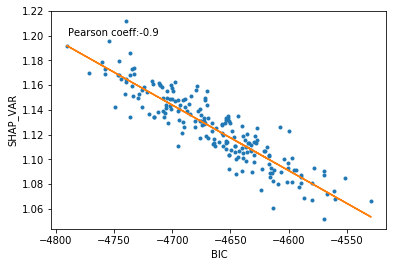

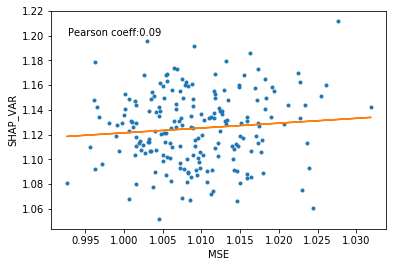

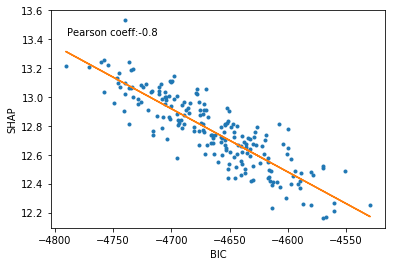

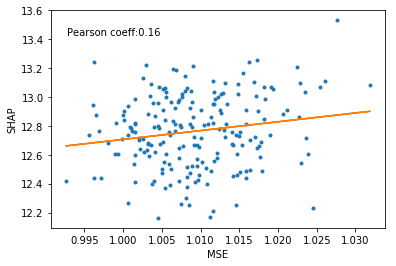

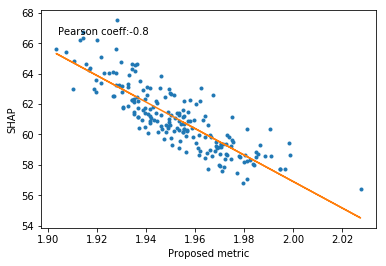

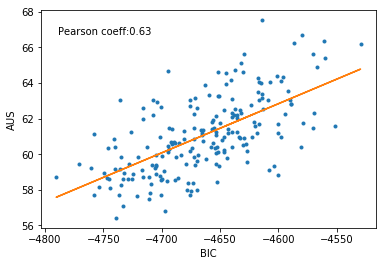

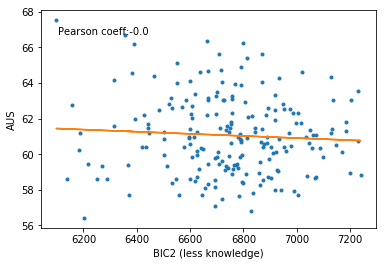

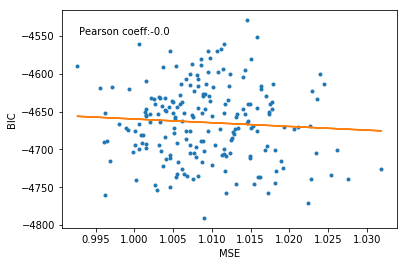

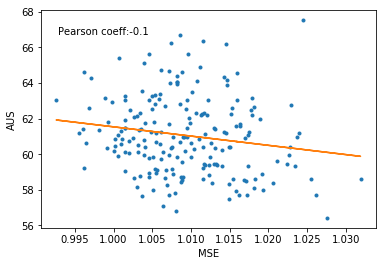

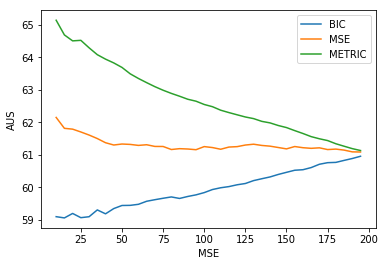

-0.8451009686685729

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (SHAP/np.max(SHAP)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO2,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO2,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO2,AUS, '.')
plt.plot(VIO2, b + m * np.array(VIO2), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC2 (less knowledge)")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [8]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + norm(np.array(MSE))
n_low = int(len(models) * 0.2)

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  1.1621297749044674
SHAP VAR Best by MSE =  1.1246592448133423
SHAP VAR Best by MET =  1.1500156816897023
SHAP VAR Random =  1.1300960339458688
SHAP Best by BIC =  13.062679602437806
SHAP Best by MSE =  12.743612608074164
SHAP Best by MET =  12.936973680006417
SHAP Random =  12.793235957516568
AUS Best by BIC =  59.18410759892411
AUS Best by MSE =  61.37217882657325
AUS Best by MET =  60.207654614213105
AUS Random =  61.00874354740267


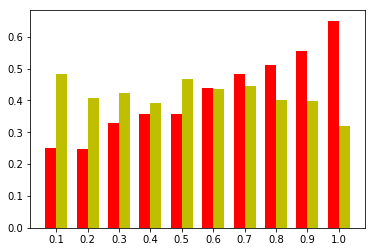

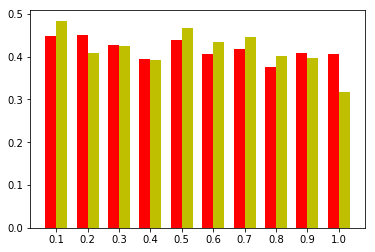

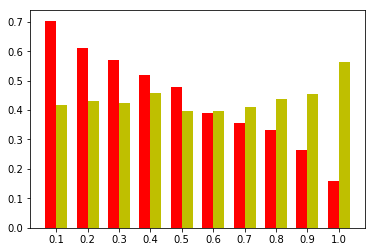

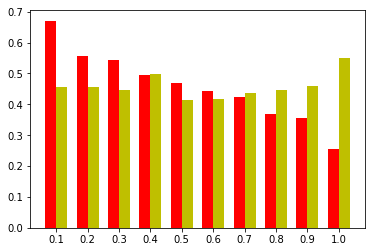

In [9]:
def plot_comparison(x1, x2, y,  bins = 10):
    sorted_y_by_x1 = [y for _,y in sorted(zip(x1,y))]
    sorted_y_by_x2 = [y for _,y in sorted(zip(x2,y))]
    total_len = len(sorted_y_by_x1)
    X = []
    Y1 = []
    Y2 = []
    for i in range(1, bins + 1):
        X.append(i / bins)
        Y1.append(np.mean(sorted_y_by_x1[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
        Y2.append(np.mean(sorted_y_by_x2[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
       
    fig, ax = plt.subplots()

    ind = np.arange(bins)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, Y1, width, color='r',)

    p2 = ax.bar(ind + width, Y2, width,
                color='y' )

    #ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(X)

    #ax.legend((p1[0], p2[0]), ('Men', 'Women'))
    #ax.yaxis.set_units(inch)
    ax.autoscale_view()

    plt.show()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
plot_comparison(VIO, MSE, normalize(AUS))
plot_comparison(VIO2, MSE, normalize(AUS))
plot_comparison(VIO, MSE, normalize(SHAP))
plot_comparison(METRIC, MSE, normalize(SHAP_VAR))
#plot_comparison(MSE, normalize(AUS))

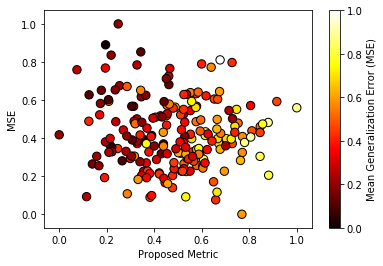

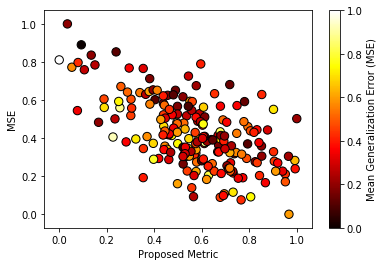

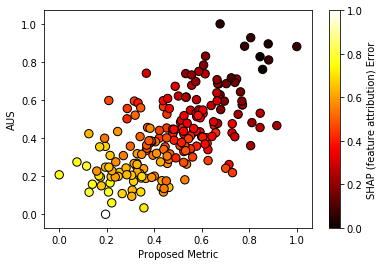

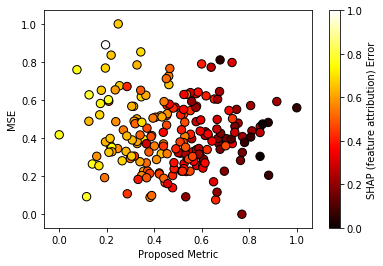

In [13]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', file = 'heat.pdf', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    fig.savefig(file, bbox = 'tight')
    
heat_plot(normalize(VIO), normalize(MSE), normalize(AUS), xlab = 'Proposed Metric', ylab = 'MSE', file = 'METRICvsMSE_Generalization.pdf')

heat_plot(normalize(VIO2), normalize(MSE), normalize(AUS), xlab = 'Proposed Metric', ylab = 'MSE', file = 'METRICvsMSE_Generalization.pdf')

heat_plot(normalize(VIO), normalize(AUS), normalize(SHAP), xlab = 'Proposed Metric', ylab = 'AUS', zlab = 'SHAP (feature attribution) Error' ,file = 'METRICvsMSE_SHAP.pdf')
heat_plot(normalize(VIO), normalize(MSE), normalize(SHAP), xlab = 'Proposed Metric', ylab = 'MSE', zlab = 'SHAP (feature attribution) Error' ,file = 'METRICvsMSE_SHAP.pdf')

1 1


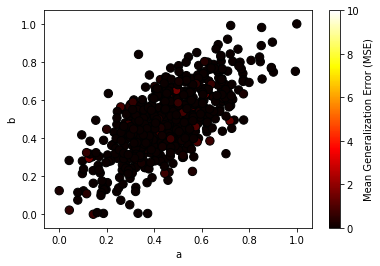

1 2


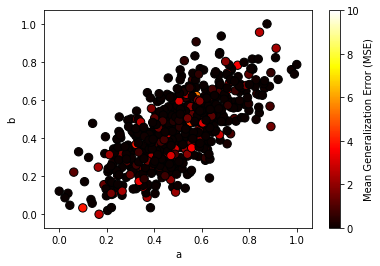

1 3


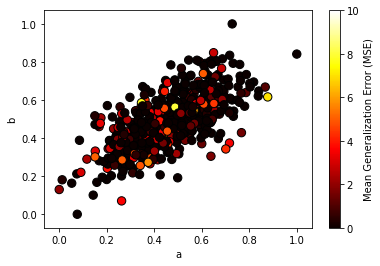

3 1


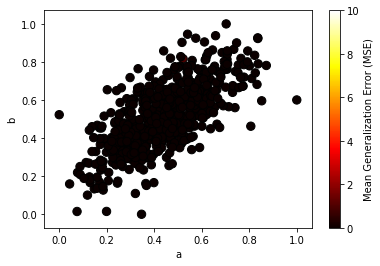

3 2


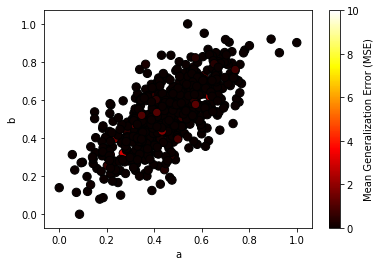

3 3


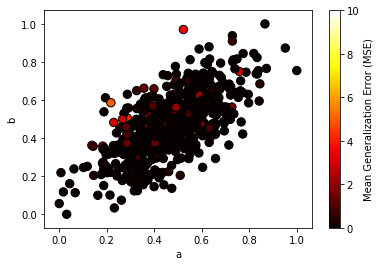

5 1


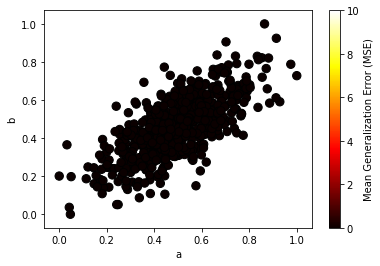

5 2


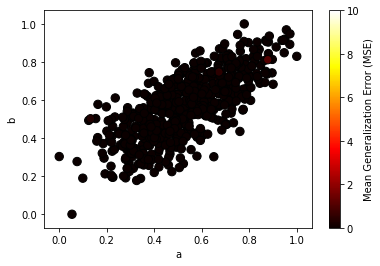

5 3


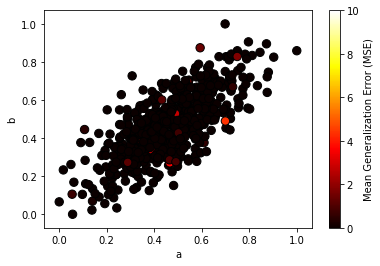

7 1


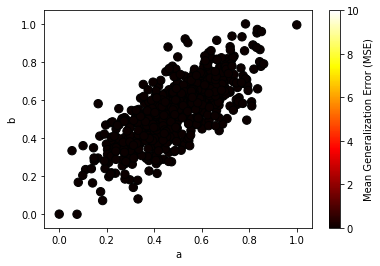

7 2


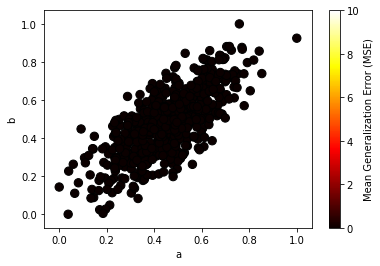

7 3


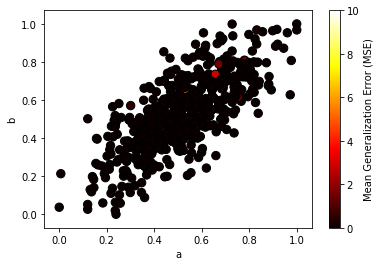

9 1


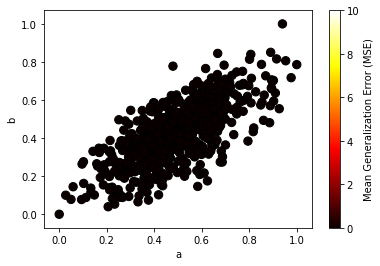

9 2


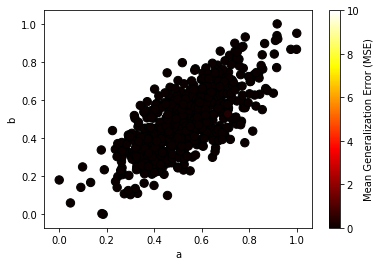

9 3


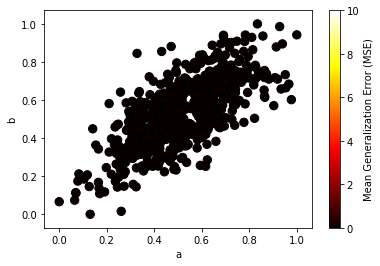

In [11]:
for m in range(1,10, 2):
    for v in range(1,4):
        print(m,v)
        df = gen_data(SIZE = 600, mean = m, var = v)
        heat_plot(normalize(df['a'].values), normalize(df['b'].values), np.squeeze(model.predict(df[['a', 'b']].values)) - df['c'].values,clim_high = 10, xlab = 'a', ylab = 'b', )